In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from stochastic_simulation.approximation import approximate, predictor_corrector_approximate, kps_approximate
from stochastic_simulation.models import *
from stochastic_simulation.wiener import generate
from stochastic_simulation.random_number_generator import generate_from_rng

In [4]:
def beta1(X):
    Xi = X[1:]
    Xi1 = X[:-1]
    num1 = (Xi * Xi1).mean()
    num2 = (Xi * Xi1.mean()).mean()
    den1 = (Xi1**2).mean()
    den2 = Xi1.mean()**2
    return (num1 - num2) / (den1 - den2)

def beta2(X):
    b1 = beta1(X)
    num = (X[1:] - b1 * X[:-1]).mean()
    return num / (1 - b1)

def beta3(X):
    b1, b2 = beta1(X), beta2(X)
    res = ((X[1:] - b1 * X[:-1] - b2 * (1 - b1))**2).mean()
    return res

In [5]:
def estimate_params(X, end_t):
    b1, b2, b3 = beta1(X), beta2(X), beta3(X)
    theta = -(X.size / end_t) * np.log(b1)
    mu = b2
    sigma = np.sqrt((2 * theta * b3) / (1 - b1**2))
    return (theta, mu, sigma)

In [6]:
orn = OrnsteinUhlenbeck(10, 3, 1, 2)

(3.1551408197390716, 1.0043379309137361, 2.044697486606735)

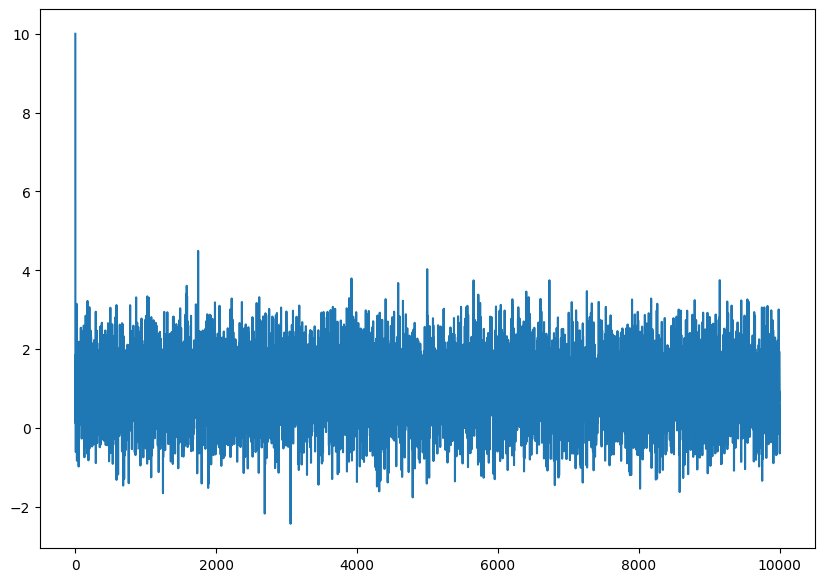

In [15]:
N = 10000
T = 10000

ts, xs = orn.generate(T, N)
ts, xs = generate_from_rng(orn.get_generator(), T, N)

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(ts, xs)
estimate_params(xs, T)

# 2

In [116]:
def theta2(X, t_end):
    frac = (X[1:] * X[:-1]).sum() / (X[:-1]**2).sum()
    return -((X.size - 1) / t_end) * np.log(frac)

def theta3(X, t_end):
    th2 = theta2(X, t_end)
    n = X.size - 1
    delta = n / t_end
    exp = np.exp(-delta * th2)
    th3_sq = 2 * th2 / (1 - exp**2) * np.mean((X[1:] - X[:-1] * exp) ** 2)
    return np.sqrt(th3_sq)

2.3979395309626597 1.744893666592474
(2.4558922027903782, 0.05769886980987122, 1.761132848477952)


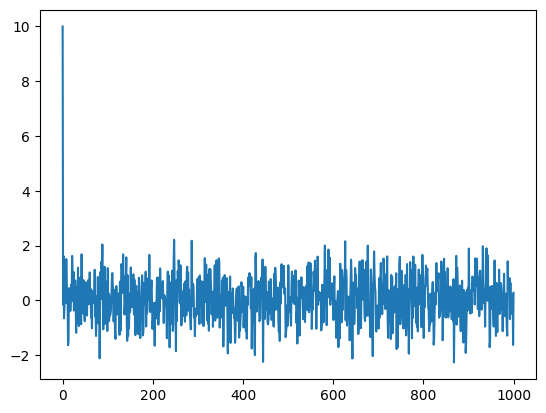

In [130]:
N = 1000
T = 1000

orn_zero = OrnsteinUhlenbeck(10, 3, 0, 2)

ts, xs = generate_from_rng(orn_zero.get_generator(), T, N)
plt.plot(ts, xs)

print(theta2(xs, T), theta3(xs, T))
print(estimate_params(xs, T))

# 3

In [355]:
from pymle.models import CKLS
from pymle.sim.Simulator1D import Simulator1D
from pymle.TransitionDensity import EulerDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
from pymle.fit.Minimizer import ScipyMinimizer

from numdifftools import Hessian

In [356]:
dt = 1e-4
T = 1
N = int(T / dt)

ckls = CKLS()
ckls.params = 1, 2, 0.5, 0.3
euler_sim = Simulator1D(S0=2, M=N-1, dt=dt, model=ckls, method='Euler')

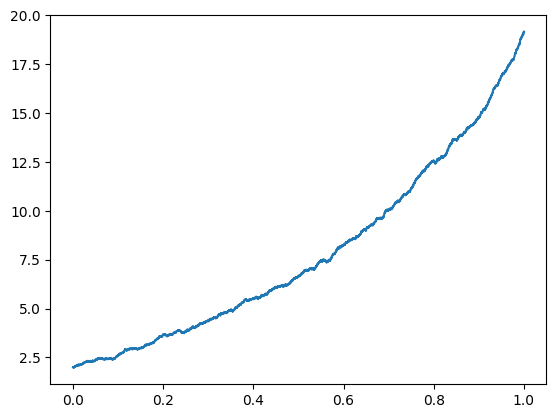

In [357]:
ts = np.linspace(0, N * dt, N)
sample = euler_sim.sim_path(1000)

for xs in sample.T[:1]:
    plt.plot(ts, xs.T)

In [358]:
bounds = [(0.5, 2), (1, 3), (0.1, 0.9), (0.1, 0.9)]
initial = np.array([1, 1.5, 0.5, 0.2])
results = []

for xs in sample.T:
    euler_estimator = AnalyticalMLE(xs, bounds, dt, EulerDensity(ckls))
    euler_estimator._minimizer = ScipyMinimizer(method='L-BFGS-B')
    res = euler_estimator.estimate_params(initial)
    results.append(res)

results = np.array([res.params for res in results])

/home/vladislav/.cache/pypoetry/virtualenvs/stochastic-prac-uipVSqoA-py3.10/lib/python3.10/site-packages/pymle/fit/Minimizer.py:77: OptimizeWarning: Unknown solver options: xtol, verbose
  res = minimize(function,


In [359]:
results_ = results.mean(axis=0)
results_

array([1.10526475, 1.65817923, 0.54168246, 0.27357887])

In [360]:
hessian = Hessian(euler_estimator.log_likelihood_negative)
hess = hessian(results_)
stds = np.sqrt(np.diag(np.linalg.inv(hess)))

q = sps.norm.ppf(1 - 0.025)
conf_ints = res.params + np.array([[-1], [1]]) * q * stds
conf_ints

array([[-1.94692139,  1.22121385,  0.50928409,  0.24357407],
       [ 4.15200443,  2.0866814 ,  0.57031176,  0.30059009]])